# Welcome to the cerf quickstarter!

## A brief introduction

The Capacity Expansion Regional Feasibility package (`cerf`) helps us evaluate the feasibility and structure of future electricity capacity expansion plans by siting power plants in areas that have been deemed the least cost option.  We can use `cerf` to gain an understanding of topics such as:  1) whether or not future projected electricity expansion plans from models such as GCAM are possible to achieve, 2) where suitability (e.g., cooling water availability) may influence our ability to achieve certain expansions, and/or 3) how power plant infrastructure build outs and value may evolve into the future when considering locational marginal pricing from a grid operations model.

`cerf` currently operates at a 1 km<sup>2</sup> resolution over the conterminous United States.  Each grid cell is given an initial value of suitable (0) or unsuitable (1) based on a collection of suitability criteria gleaned from the literature.  `cerf`'s default suitability layers include both those that are common to all thermal technologies as well as technology-specific suitability criteria.  Common suitability layers represent categories such as protected lands, critical habitat areas, and much more.  Technology-specific suitability layers are those that satisfy requirements that may not be applicable to all technologies.  An example would be minimum mean annual flow requirements for cooling water availability for individual thermal technologies.

We introduce a metric named **Net Locational Cost (NLC)** that is used compete power plant technologies for each grid cell based on the least expensive option.  NLC is calculated by subtracting the Net Operational Value (NOV) of the proposed power plant from the cost of its interconnection to the grid to represent the potential deployment value.  Both the NOV parameter which incorporates many technology-specific values such as variable operations and maintenance costs, carbon price, heat rate, etc. and the interconnection cost parameter used for both electricity transmission and gas pipelines have variables that are accessible to the user for modification per time step.


## Load packages

In [1]:
import cerf


## Conduct a run with CERF

We will be exploring the main functionality of the `cerf` package using our built-in data which is meant for illustrative purposes only.  `cerf` runs using a single YAML configuration file that contains project and technology-specific settings, an electricity capacity expansion plan, and lmp zones pricing data which is described in detail in the docs [here](https://immm-sfa.github.io/cerf/).  Expansion plans and technology data are generally generated by models such as GCAM-USA which capture multi-sector dynamics that represent alternate futures based on scenario assumptions for socioeconomics, radiative forcing, etc. The `cerf` package also utilizes power plant siting suitability data at a 1km resolution over the CONUS, publically available data from EIA and HIFLD for transmission and pipeline infrastructure, and 8760 locational marginal pricing from your prefered grid operations model.


### Get up and running right away!


#### Run `cerf` to site power plants in an expansion plan for a single year for the CONUS

In [2]:
# sample year
yr = 2010

# load the sample configuration file path for the target year
config_file = cerf.config_file(yr)

# run the configuration for the target year and return a data frame
result_df = cerf.run(config_file, write_output=False)


2021-07-15 09:37:59,707 - root - INFO - Starting CERF model
2021-07-15 09:37:59,753 - root - INFO - Staging data...
2021-07-15 09:37:59,965 - root - INFO - Using 'zones_raster_file':  /Users/d3y010/repos/github/cerf/cerf/data/lmp_zones_1km.img
2021-07-15 09:38:00,000 - root - INFO - Processing locational marginal pricing (LMP)
2021-07-15 09:38:00,001 - root - INFO - Using LMP from default illustrative package data:  /Users/d3y010/repos/github/cerf/cerf/data/illustrative_lmp_8760-per-zone_dollars-per-mwh.zip
2021-07-15 09:38:01,888 - root - INFO - Calculating interconnection costs (IC)
2021-07-15 09:38:19,085 - root - INFO - Calculating net operational cost (NOV)
2021-07-15 09:38:19,329 - root - INFO - Calculating net locational cost (NLC)
2021-07-15 09:38:19,440 - root - INFO - Building suitability array
2021-07-15 09:38:19,516 - root - INFO - Using suitability file for 'biomass':  /Users/d3y010/repos/github/cerf/cerf/data/suitability_biomass.sdat
2021-07-15 09:38:19,550 - root - INFO 

#### `cerf` results are returned as a Pandas DataFrame

Each record is a sited power plant having a geographic location and other siting attributes. Reminder:  `cerf` uses the USA_Contiguous_Albers_Equal_Area_Conic projected coordinate reference system, so the `xcoord` and `ycoord` are relative to that projection.


In [3]:
result_df.head()

,state_name,tech_id,tech_name,xcoord,ycoord,index,buffer_in_km,sited_year,retirement_year,lmp_zone,locational_marginal_pricing,net_operational_value,interconnection_cost,net_locational_cost
0,alabama,11,nuclear,8.189472e+05,-577565.2005,10266815,5,2010,2070,36,178.754021,5.182452e+09,0.0,-5.182452e+09
1,alabama,11,nuclear,7.959472e+05,-424565.2005,9548763,5,2010,2070,36,178.754021,5.182452e+09,0.0,-5.182452e+09
2,alabama,11,nuclear,8.179472e+05,-439565.2005,9619180,5,2010,2070,36,178.754021,5.182452e+09,0.0,-5.182452e+09
3,alabama,11,nuclear,8.259472e+05,-391565.2005,9393924,5,2010,2070,36,178.754021,5.182452e+09,0.0,-5.182452e+09
0,arizona,9,biomass,-1.291053e+06,-189565.2005,8443821,5,2010,2070,44,137.431643,5.399856e+07,0.0,-5.399856e+07


#### Run `cerf` to site power plants in an expansion plan for multiple years for the CONUS

This exercise demonstrates how to inherit sites from a previous year's results and keep them in the mix if they have not yet reached retirement.  If this is done in `cerf`, users should ensure that their expansion plan is only for new vintage each timestep.


In [2]:
import cerf

# process year 2010 and 2050
for index, yr in enumerate([2010, 2050]):

    print(f"\nProcessing year:  {yr}")

    # load the sample configuration file path for the target year
    config_file = cerf.config_file(yr)

    # do not intialize the run with previously sited data if it is the first time step
    if index == 0:
        result_df = cerf.run(config_file, write_output=False)

    else:
        result_df = cerf.run(config_file,
                                 write_output=False,
                                 initialize_site_data=result_df)



Processing year:  2010
2021-07-15 10:48:47,876 - root - INFO - Starting CERF model
2021-07-15 10:48:47,924 - root - INFO - Staging data...
2021-07-15 10:48:48,138 - root - INFO - Using 'zones_raster_file':  /Users/d3y010/repos/github/cerf/cerf/data/lmp_zones_1km.img
2021-07-15 10:48:48,173 - root - INFO - Processing locational marginal pricing (LMP)
2021-07-15 10:48:48,174 - root - INFO - Using LMP from default illustrative package data:  /Users/d3y010/repos/github/cerf/cerf/data/illustrative_lmp_8760-per-zone_dollars-per-mwh.zip
2021-07-15 10:48:50,059 - root - INFO - Calculating interconnection costs (IC)
2021-07-15 10:49:06,929 - root - INFO - Calculating net operational cost (NOV)
2021-07-15 10:49:07,168 - root - INFO - Calculating net locational cost (NLC)
2021-07-15 10:49:07,276 - root - INFO - Building suitability array
2021-07-15 10:49:07,352 - root - INFO - Using suitability file for 'biomass':  /Users/d3y010/repos/github/cerf/cerf/data/suitability_biomass.sdat
2021-07-15 10:

#### Explore the results that account for retirement

Since we inherited the each year, and we are only siting new vintage per year, we see power plants from multiple technlogies until they reach their retirement age.  We can narrow in on `biomass` power plants in Virginia to see this:


In [3]:
result_df.loc[(result_df['state_name'] == 'virginia') & (result_df['tech_id'] == 9)]


,state_name,tech_id,tech_name,xcoord,ycoord,index,buffer_in_km,sited_year,retirement_year,lmp_zone,locational_marginal_pricing,net_operational_value,interconnection_cost,net_locational_cost
0,virginia,9,biomass,1.770947e+06,240434.7995,6428893,5,2010,2070,30,173.692324,6.947415e+07,0.000000,-6.947415e+07
1,virginia,9,biomass,1.765947e+06,246434.7995,6400730,5,2010,2070,30,173.692324,6.947415e+07,35.817509,-6.947411e+07
0,virginia,9,biomass,1.761947e+06,240434.7995,6428884,5,2050,2110,30,173.692324,6.947415e+07,107.452536,-6.947404e+07
1,virginia,9,biomass,1.776947e+06,243434.7995,6414820,5,2050,2110,30,173.692324,6.947415e+07,147.679370,-6.947400e+07


#### Plot the output

<AxesSubplot:>

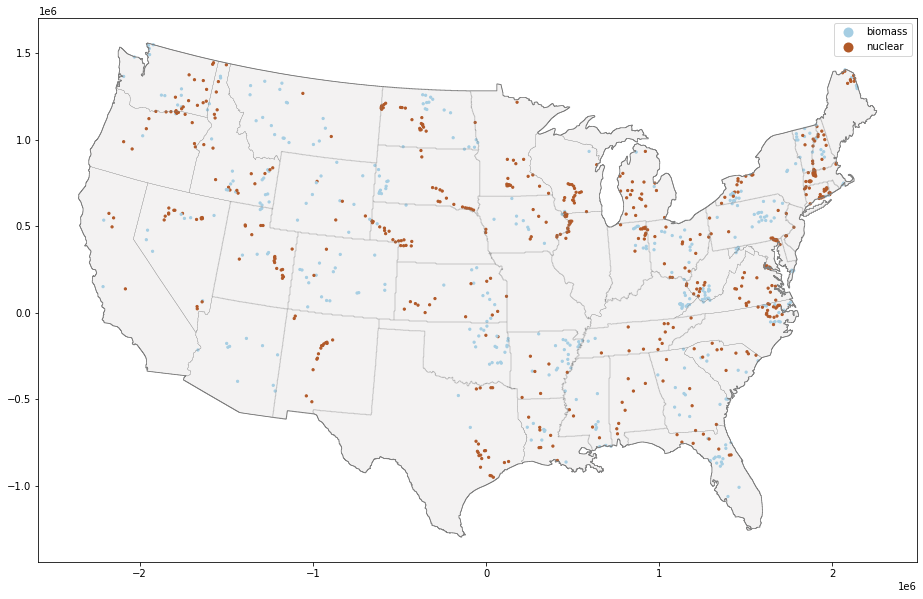

In [4]:
cerf.plot_siting(result_df)

In [ ]:
# generate plot
sns.set(font_scale=2) 

fig, ax = plt.subplots(figsize=(20, 10))

plt.title("EIA power plant interactions with CERF common suitability")

suitable_color = "#d0e1e1"
unsuitable_color = "#f3f2f2"

cmap = ListedColormap([suitable_color, unsuitable_color])

with rasterio.open(cerf_common_suitability_masked_file) as src:
    
    # boundary_gdf.plot(ax=ax, facecolor='lightgray')
    show(src, ax=ax, cmap=cmap) #, interpolation='none', ax=ax)
    states_gdf.boundary.plot(ax=ax, edgecolor='gray', lw=0.2)
    boundary_gdf.boundary.plot(ax=ax, edgecolor='gray', lw=0.8)
    suitable_power_plants.plot(ax=ax, color='green', markersize=5)
    unsuitable_power_plants.plot(ax=ax, color='red', markersize=5)

    # construct legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=12, label='Valid'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=12, label='Invalid'),
                       Patch(facecolor=suitable_color, label='Suitable'),
                       Patch(facecolor=unsuitable_color, label='Unsuitable')]

    ax.legend(handles=legend_elements,
              bbox_to_anchor=(1.05, 1),
              facecolor="white",
              frameon=False)

    ax.set_axis_off()

    sns.set(font_scale=1)
    


In [7]:
import os

import rasterio

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point


import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap




In [8]:
root_dir = '/Users/d3y010/projects/cerf/data'

cerf_states_file = os.path.join(root_dir, 'gis', 'shp', 'Promod_20121028_fips.shp')
cerf_conus_file = os.path.join(root_dir, 'gis', 'shp', 'cerf_conus_boundary.shp')


target_crs = cerf.cerf_crs()

states_gdf = gpd.read_file(cerf_states_file).to_crs(target_crs)
boundary_gdf = gpd.read_file(cerf_conus_file).to_crs(target_crs)




In [10]:
# create geometry column from coordinate fields
geometry = [Point(xy) for xy in zip(result_df['xcoord'], result_df['ycoord'])]



In [31]:
gdf = gpd.GeoDataFrame(result_df, crs=target_crs, geometry=geometry)


In [57]:
type(gdf.crs)

pyproj.crs.crs.CRS

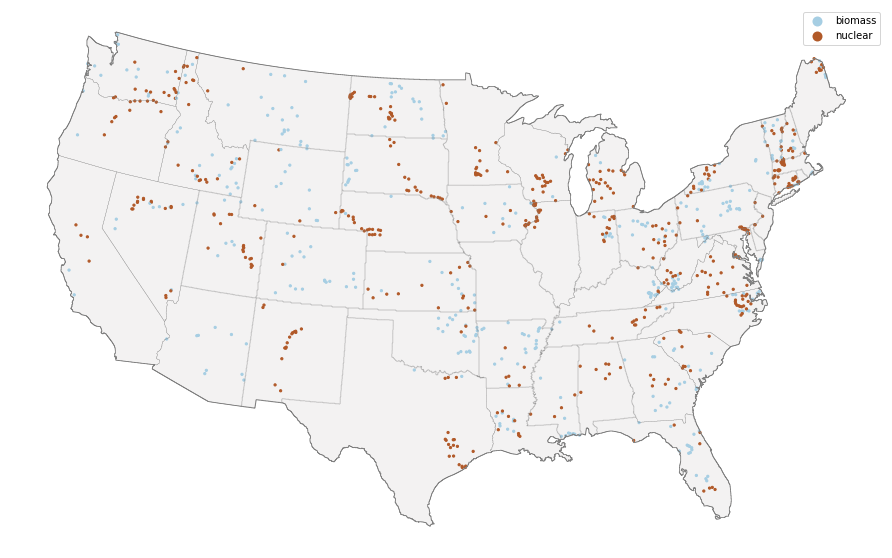

In [48]:
fig, ax = plt.subplots(figsize=(20, 10))

tech1 = 'red'
tech2 = 'green'


cmap = ListedColormap(['red', 'green'])


boundary_gdf.plot(ax=ax, color="#f3f2f2", lw=0.8)
states_gdf.boundary.plot(ax=ax, edgecolor='gray', lw=0.2)
boundary_gdf.boundary.plot(ax=ax, edgecolor='gray', lw=0.8)

gdf.plot(ax=ax, markersize=5, column='tech_name', cmap='Paired', legend=True)#, color='green', markersize=5)

# # construct legend
# legend_elements = [Patch(facecolor=tech1, label='Suitable'),
#                    Patch(facecolor=tech2, label='Unsuitable')]

# ax.legend(handles=legend_elements,
#           bbox_to_anchor=(1.05, 1),
#           facecolor="white",
#           frameon=False)

ax.set_axis_off()

